# **Import thư viện**

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **Tiền xử lý dữ liệu**

In [3]:
# Đọc dữ liệu
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


In [4]:

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
test_df.head()


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
# Làm sạch văn bản
def clean_text(text):
    # Chuyển về chữ thường
    text = str(text).lower()
    # Thay thế xuống dòng bằng khoảng trắng
    text = re.sub(r'\n', ' ', text)
    # Chỉ giữ lại chữ cái và số, bỏ ký tự đặc biệt
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Xóa khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['clean_text'] = train_df['comment_text'].apply(clean_text)
test_df['clean_text'] = test_df['comment_text'].apply(clean_text)

In [7]:
# Chia tập Train và Val
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
X = train_df['clean_text']
y = train_df[list_classes].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print("Ví dụ văn bản sau khi làm sạch:", X_train.iloc[0])


Ví dụ văn bản sau khi làm sạch: outrageous this block is outrageous and unwiki lauren caitlin is about a trillion times more important beloved and prominent than at least 99 of all the article subjects on this joke of a site why oh why are wikipedias administrators so freaking aretentive and have such an inferiority complex and fragile egos do all of you have to ruin the fun and enthusiasm of the rest of us members just because you need to feel powerful and important so desperately are all of you school marm librarian types in wool sweaters with thick glasses afraid of the thought of romance and fun sheesh this lauren caitlin upton bio page better be approved quickly and available for work america cant wait any longer for the wikipedia administrator moron club and assorted other freak wikipedia unions to get a life dont you people have jobs or do you just play with yourselves here while youre playing with and tormenting the rest of us contributors


# **Model Basline**

In [8]:
# Biến đổi văn bản thành số
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, stop_words='english')),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear')))
])

pipeline.fit(X_train, y_train)

# Đánh giá
y_pred_val_prob = pipeline.predict_proba(X_val)
score = roc_auc_score(y_val, y_pred_val_prob)
print(score)

0.9771611727553428


# **Xây dựng Vocab và Dataset**

In [9]:
# Xây dựng từ điển (Tokenization)
# Gom tất cả từ vựng lại và chọn ra những từ xuất hiện nhiều nhất
all_text = " ".join(X_train.tolist())
words = all_text.split()
count_words = Counter(words)

# Chỉ giữ lại 20000 từ phổ biến nhất
MAX_VOCAB_SIZE = 20000
sorted_words = count_words.most_common(MAX_VOCAB_SIZE)

# Tạo dictionary mapping: word -> integer
word_to_idx = {w: i+2 for i, (w, c) in enumerate(sorted_words)}
word_to_idx['<PAD>'] = 0
word_to_idx['<UNK>'] = 1

print(f"Index của <PAD>: {word_to_idx['<PAD>']}")
print(f"Index của <UNK>: {word_to_idx['<UNK>']}")
print(f"Index của từ '{sorted_words[0][0]}': {word_to_idx[sorted_words[0][0]]}")

Index của <PAD>: 0
Index của <UNK>: 1
Index của từ 'the': 2


In [10]:
# Class Dataset
class ToxicDataset(Dataset):
    def __init__(self, texts, labels, word_to_idx, max_len=100):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels
        self.word_to_idx = word_to_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        # Tách từ
        tokens = text.split()
        # Chuyển từ thành số (nếu từ không có trong dict thì lấy 0)
        vec = [self.word_to_idx.get(w, 0) for w in tokens]
        # Cắt bớt hoặc thêm số 0 cho đủ độ dài max_len
        if len(vec) < self.max_len:
            vec = vec + [0] * (self.max_len - len(vec))
        else:
            vec = vec[:self.max_len]

        return torch.tensor(vec, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float32)

# **Dataloader**

In [11]:
# Tạo DataLoader
MAX_LEN = 128  # Độ dài tối đa của một câu
BATCH_SIZE = 64

train_dataset = ToxicDataset(X_train,
                             y_train,
                             word_to_idx,
                             max_len=MAX_LEN)

val_dataset = ToxicDataset(X_val, y_val,
                           word_to_idx,
                           max_len=MAX_LEN)

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

# **Model LSTM**

In [12]:
class ToxicLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.3):
        super(ToxicLSTM, self).__init__()

        # Chuyển index số nguyên thành vector
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # mô hình đọc từ trái sang phải và phải sang trái
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            batch_first=True,
                            bidirectional=True)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embed = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embed)

        # Nối trạng thái ẩn của chiều xuôi và chiều ngược lại
        # hidden[-2] là chiều xuôi, hidden[-1] là chiều ngược
        hidden_concat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        out = self.dropout(hidden_concat)
        out = self.fc(out)
        return out

# Khởi tạo mô hình
VOCAB_SIZE = len(word_to_idx) + 1
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 6

model = ToxicLSTM(VOCAB_SIZE,
                  EMBEDDING_DIM,
                  HIDDEN_DIM,
                  OUTPUT_DIM).to(device)
print(model)

ToxicLSTM(
  (embedding): Embedding(20003, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)


# **Train model**

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for i, (texts, labels) in enumerate(iterator):
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in iterator:
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts)
            loss = criterion(predictions, labels)
            epoch_loss += loss.item()

            # Lưu lại để tính ROC-AUC
            probs = torch.sigmoid(predictions).cpu().numpy()
            all_preds.append(probs)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    auc_score = roc_auc_score(all_labels, all_preds)

    return epoch_loss / len(iterator), auc_score

train_losses = []
val_losses = []

N_EPOCHS = 6

for epoch in range(N_EPOCHS):
    # Chạy train và evaluate
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, val_auc = evaluate(model, val_loader, criterion)

    # TỰ ĐỘNG LƯU DỮ LIỆU VÀO LIST
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f}')

Epoch: 01 | Train Loss: 0.0902 | Val Loss: 0.0568 | Val AUC: 0.9607
Epoch: 02 | Train Loss: 0.0535 | Val Loss: 0.0501 | Val AUC: 0.9733
Epoch: 03 | Train Loss: 0.0465 | Val Loss: 0.0477 | Val AUC: 0.9772
Epoch: 04 | Train Loss: 0.0416 | Val Loss: 0.0476 | Val AUC: 0.9780
Epoch: 05 | Train Loss: 0.0377 | Val Loss: 0.0478 | Val AUC: 0.9789
Epoch: 06 | Train Loss: 0.0333 | Val Loss: 0.0509 | Val AUC: 0.9782


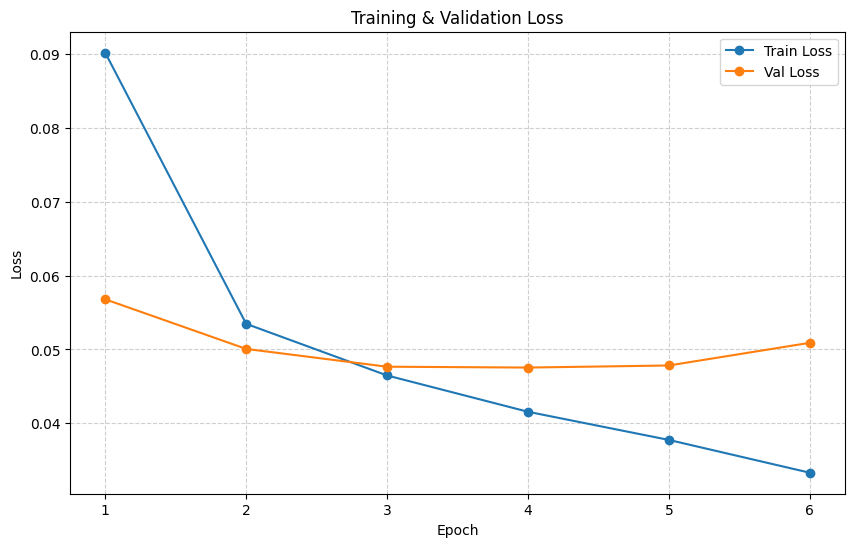

In [15]:
import matplotlib.pyplot as plt

# Tạo trục x (số epoch)
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))

# Vẽ 2 đường Train và Val Loss
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o', color='tab:blue')
plt.plot(epochs_range, val_losses, label='Val Loss', marker='o', color='tab:orange')

# Gắn nhãn
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

# **Save model**

In [16]:
import pickle

# Lưu trọng số của Model
torch.save(model.state_dict(), 'saved_model.pth')

# Lưu Từ điển
with open('vocab.pkl', 'wb') as f:
    pickle.dump(word_to_idx, f)